In [1]:
from fastlane_bot import Config, ConfigDB, ConfigNetwork, ConfigProvider, Bot
from fastlane_bot.tools.cpc import ConstantProductCurve as CPC, CPCContainer
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(Bot))
from fastlane_bot.testing import *
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
from fastlane_bot import __VERSION__
require("2.0", __VERSION__)

ConstantProductCurve v2.6.4.2 (30/Apr/2023)
CarbonBot v2.0-BETA4 (30/Apr/2023)
imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require


C:\Users\nicho\AppData\Local\Temp\ipykernel_25068\1877708567.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


Version = 2.0-BETA4 [requirements >= 2.0 is met]


# Testing the _run functions [NBTest011]

## Mainnet Alchemy Configuration

### Set up the bot

In [2]:
C = Config.new(config=Config.CONFIG_MAINNET)
assert C.DATABASE == C.DATABASE_POSTGRES
assert C.POSTGRES_DB == "mainnet"
assert C.NETWORK == C.NETWORK_MAINNET
assert C.PROVIDER == C.PROVIDER_ALCHEMY
bot = Bot(ConfigObj=C)

In [3]:
help(bot._run)
#help(CPC.from_carbon)
#help(CPC.from_univ3)

Help on method _run in module fastlane_bot.bot:

_run(flashloan_tokens: List[str], CCm: fastlane_bot.tools.cpc.CPCContainer, *, result=None, network: str = 'mainnet') -> Optional[Tuple[str, List[Any]]] method of fastlane_bot.bot.CarbonBot instance
    Working-level entry point for run(), performing the actual execution.
    
    Parameters
    ----------
    flashloan_tokens: List[str]
        The flashloan tokens, ie all tokens that can be borrowed.
    CCm: CPCContainer
        The CPCContainer object containing all market curves.
    result: XS_XXX or None
        What intermediate result to return (default: None)
    
    Returns
    -------
    str
        The transaction hash.



### Set up the curves

In [4]:
cc1 = CPC.from_carbon(pair="ETH/USDC", tkny="ETH", yint=10, y=10, pa=1/2000, pb=1/2010, cid="c-1")
assert iseq(1/2000, cc1.p, cc1.p_max)
assert iseq(1/2010, cc1.p_min)
assert cc1.p_convention() == 'ETH per USDC'
assert cc1.p_min < cc1.p_max
cc1

ConstantProductCurve(k=32240349875.23444, x=8029987.531152765, x_act=0, y_act=10, pair='USDC/ETH', cid='c-1', fee=None, descr=None, constr='carb', params={'y': 10, 'yint': 10, 'A': 5.569293772436992e-05, 'B': 0.022304986837273527, 'pa': 0.0005, 'pb': 0.0004975124378109452})

In [5]:
cu1 = CPC.from_univ3(pair="ETH/USDC", Pmarg=2100, uniPa=2000, uniPb=2200, 
                     uniL=200*m.sqrt(2100*2100), fee=0, cid="uni1", descr="")
assert iseq(cu1.p, 2100)
assert iseq(cu1.p_min, 2000)
assert iseq(cu1.p_max, 2200)
assert cu1.p_convention() == 'USDC per ETH'
assert cu1.p_min < cu1.p_max
cu1

ConstantProductCurve(k=176400000000.0, x=9165.15138991168, x_act=210.72130297604053, y_act=463846.9078162946, pair='ETH/USDC', cid='uni1', fee=0, descr='', constr='pkpp', params={'L': 420000.0})

In [6]:
cu1.p, cc1.p

(2100.0, 0.0005)

pair = USDC/ETH


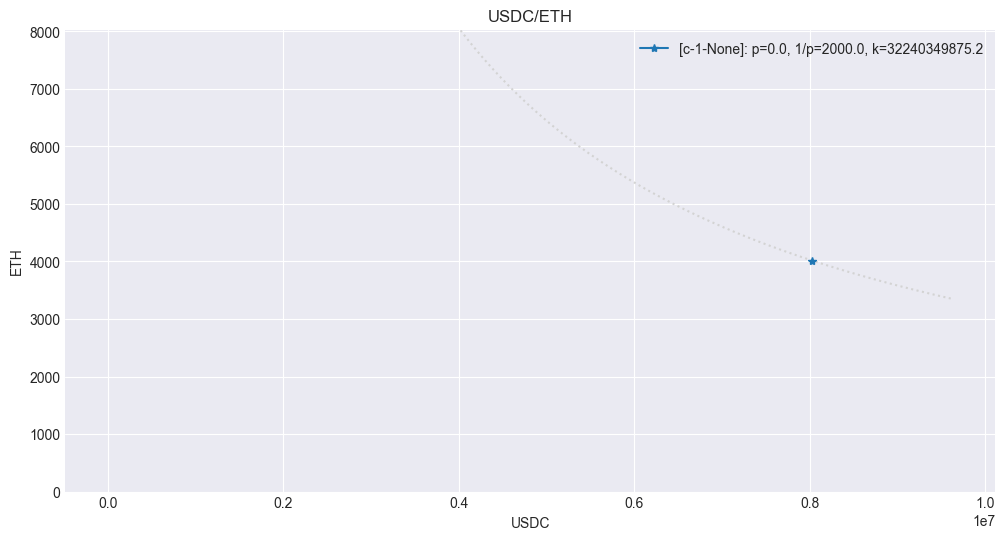

pair = ETH/USDC


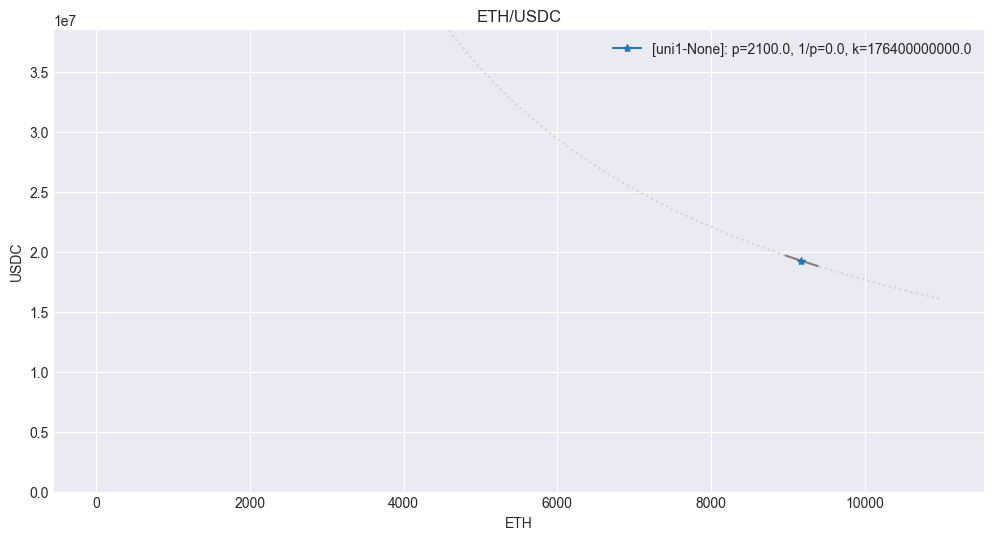

In [7]:
CCm = CPCContainer([cu1, cc1])
CCm.plot()

### Run `_find_arbitrage_opportunities}`

#### AO_TOKENS

In [8]:
r=bot._find_arbitrage_opportunities(flashloan_tokens=["USDC"], CCm=CCm, result=bot.AO_TOKENS)
r

({'ETH', 'USDC'}, [('ETH', 'USDC')])

In [9]:
assert r[0] == {'ETH', 'USDC'}
assert r[1] == [('ETH', 'USDC')]

#### AO_CANDIDATES

In [10]:
bot._find_arbitrage_opportunities(flashloan_tokens=["USDC"], CCm=CCm, result=bot.AO_CANDIDATES)

Profit in bnt: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008 ['uni1', 'c-1']
bnt_gas_limit: 319.9133248165296983245298179099336266517639160156250
profit > best_profit: True
profit > best_profit: True
contains_carbon: True
max(netchange)<1e-4: True
*************
New best profit: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008
best_trade_instructions_df:                     ETH          USDC
uni1       1.000000e+01 -20977.111872
c-1       -1.000000e+01  20049.937656
AMMIn      1.000000e+01  20049.937656
AMMOut    -1.000000e+01 -20977.111872
TOTAL NET -1.062617e-07   -927.174216
*************


[(Decimal('1977.43590718109779343899662351065063200811905419485015045211184769868850708008'),
                      ETH          USDC
  uni1       1.000000e+01 -20977.111872
  c-1       -1.000000e+01  20049.937656
  AMMIn      1.000000e+01  20049.937656
  AMMOut    -1.000000e+01 -20977.111872
  TOTAL NET -1.062617e-07   -927.174216,
  [{'cid': 'uni1',
    'tknin': 'ETH',
    'amtin': 9.999999893738277,
    'tknout': 'USDC',
    'amtout': -20977.111871615052,
    'error': None},
   {'cid': 'c-1',
    'tknin': 'USDC',
    'amtin': 20049.9376557637,
    'tknout': 'ETH',
    'amtout': -10.0,
    'error': None}],
  'USDC',
  (CPCArbOptimizer.TradeInstruction(cid='uni1', tknin='ETH', amtin=9.999999893738277, tknout='USDC', amtout=-20977.111871615052, error=None),
   CPCArbOptimizer.TradeInstruction(cid='c-1', tknin='USDC', amtin=20049.9376557637, tknout='ETH', amtout=-10.0, error=None)))]

#### Full

In [11]:
r = bot._find_arbitrage_opportunities(flashloan_tokens=["USDC"], CCm=CCm)

Profit in bnt: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008 ['uni1', 'c-1']
bnt_gas_limit: 319.9133248165296983245298179099336266517639160156250
profit > best_profit: True
profit > best_profit: True
contains_carbon: True
max(netchange)<1e-4: True
*************
New best profit: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008
best_trade_instructions_df:                     ETH          USDC
uni1       1.000000e+01 -20977.111872
c-1       -1.000000e+01  20049.937656
AMMIn      1.000000e+01  20049.937656
AMMOut    -1.000000e+01 -20977.111872
TOTAL NET -1.062617e-07   -927.174216
*************


In [12]:
r[4]

(CPCArbOptimizer.TradeInstruction(cid='uni1', tknin='ETH', amtin=9.999999893738277, tknout='USDC', amtout=-20977.111871615052, error=None),
 CPCArbOptimizer.TradeInstruction(cid='c-1', tknin='USDC', amtin=20049.9376557637, tknout='ETH', amtout=-10.0, error=None))

### Run `_run`

#### XS_ARBOPPS

In [13]:
bot._run(flashloan_tokens=["USDC"], CCm=CCm, result=bot.XS_ARBOPPS)

Profit in bnt: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008 ['uni1', 'c-1']
bnt_gas_limit: 319.9133248165296983245298179099336266517639160156250
profit > best_profit: True
profit > best_profit: True
contains_carbon: True
max(netchange)<1e-4: True
*************
New best profit: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008
best_trade_instructions_df:                     ETH          USDC
uni1       1.000000e+01 -20977.111872
c-1       -1.000000e+01  20049.937656
AMMIn      1.000000e+01  20049.937656
AMMOut    -1.000000e+01 -20977.111872
TOTAL NET -1.062617e-07   -927.174216
*************


(Decimal('1977.43590718109779343899662351065063200811905419485015045211184769868850708008'),
                     ETH          USDC
 uni1       1.000000e+01 -20977.111872
 c-1       -1.000000e+01  20049.937656
 AMMIn      1.000000e+01  20049.937656
 AMMOut    -1.000000e+01 -20977.111872
 TOTAL NET -1.062617e-07   -927.174216,
 [{'cid': 'uni1',
   'tknin': 'ETH',
   'amtin': 9.999999893738277,
   'tknout': 'USDC',
   'amtout': -20977.111871615052,
   'error': None},
  {'cid': 'c-1',
   'tknin': 'USDC',
   'amtin': 20049.9376557637,
   'tknout': 'ETH',
   'amtout': -10.0,
   'error': None}],
 'USDC',
 (CPCArbOptimizer.TradeInstruction(cid='uni1', tknin='ETH', amtin=9.999999893738277, tknout='USDC', amtout=-20977.111871615052, error=None),
  CPCArbOptimizer.TradeInstruction(cid='c-1', tknin='USDC', amtin=20049.9376557637, tknout='ETH', amtout=-10.0, error=None)))

#### XS_TI

In [14]:
bot._run(flashloan_tokens=["USDC"], CCm=CCm, result=bot.XS_TI)

Profit in bnt: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008 ['uni1', 'c-1']
bnt_gas_limit: 319.9133248165296983245298179099336266517639160156250
profit > best_profit: True
profit > best_profit: True
contains_carbon: True
max(netchange)<1e-4: True
*************
New best profit: 1977.43590718109779343899662351065063200811905419485015045211184769868850708008
best_trade_instructions_df:                     ETH          USDC
uni1       1.000000e+01 -20977.111872
c-1       -1.000000e+01  20049.937656
AMMIn      1.000000e+01  20049.937656
AMMOut    -1.000000e+01 -20977.111872
TOTAL NET -1.062617e-07   -927.174216
*************


AttributeError: 'TradeInstruction' object has no attribute 'db'

#### XS_ORDSCAL

In [ ]:
bot._run(flashloan_tokens=["USDC"], CCm=CCm, result=bot.XS_ORDSCAL)

#### XS_AGGTI

In [ ]:
bot._run(flashloan_tokens=["USDC"], CCm=CCm, result=bot.XS_AGGTI)

#### XS_ORDTI

In [ ]:
bot._run(flashloan_tokens=["USDC"], CCm=CCm, result=bot.XS_ORDTI)

#### XS_ENCTI

In [ ]:
bot._run(flashloan_tokens=["USDC"], CCm=CCm, result=bot.XS_ENCTI)

#### XS_ROUTE

In [ ]:
bot._run(flashloan_tokens=["USDC"], CCm=CCm, result=bot.XS_ROUTE)